In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
from scipy.signal import resample_poly

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/code/neuropixels/src')
import path_formatting as pf
import motive
import oe

In [2]:
date = "20250718" # change this according to ur session
animal = "eb02"

oe_sr = 30000
m_sr = 120

csv_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\motive\out_csv'
csv_path = pf.w2l(csv_path)

dat_path = rf'X:\eva\data\raw\oe\{animal}\{animal}_{date}\continuous.dat'
dat_path = pf.w2l(dat_path)

ks_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\kilosort'
ks_path = pf.w2l(ks_path)

res_path = rf'X:\eva\code\neuropixels\results\{animal}\{animal}_{date}'
res_path = pf.w2l(res_path)
os.makedirs(res_path, exist_ok=True) # Create the folder if it doesn't exist

pf_path = Path(res_path) / "pf"
pf_path.mkdir(parents=True, exist_ok=True) # Create the folder if it doesn't exist

csv_path, dat_path, ks_path, res_path, pf_path

('/storage3/eva/data/processed/eb02/eb02_20250718/motive/out_csv',
 '/storage3/eva/data/raw/oe/eb02/eb02_20250718/continuous.dat',
 '/storage3/eva/data/processed/eb02/eb02_20250718/kilosort',
 '/storage3/eva/code/neuropixels/results/eb02/eb02_20250718',
 PosixPath('/storage3/eva/code/neuropixels/results/eb02/eb02_20250718/pf'))

In [3]:
goodspiketimes = oe.ks_load(ks_path)
res_path_path = Path(res_path)
with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
73 phy-good clusters


In [4]:
pyr = [7,26,45,53,56,64,68,79,83,89,90,115,125,137,167,178,183,189,228,230,232,233,234,256,403,414,426,427,428,429,430,434,441,444,445,446,455,457,458,460,470,471,472,473,474,475,476,477,494,495,512,513,516,519,545]
inter = [70,78,105,110,138,153,154,204,220,227,492,493]

In [ ]:
# def invert_interneuron_spikes(goodspiketimes, inter, sampling_end=None):
#     # 1. Find the max sample time if not specified
#     if sampling_end is None:
#         sampling_end = max([spikes.max() for spikes in goodspiketimes.values()])

#     # 2. Create full set of time samples
#     all_possible_times = set(np.arange(0, sampling_end + 1))

#     # 3. Create new dict for inverted spikes
#     inverted_dict = {}

#     for neuron_id in inter:
#         if neuron_id not in goodspiketimes:
#             continue  # Skip if neuron ID not in original data

#         real_spikes = set(goodspiketimes[neuron_id])
#         inverted_spikes = sorted(all_possible_times - real_spikes)

#         inverted_dict[neuron_id] = np.array(inverted_spikes, dtype=np.int64)

#     return inverted_dict
# inverted_spikes = invert_interneuron_spikes(goodspiketimes, inter)

In [5]:
def invert_interneuron_spikes_fast(goodspiketimes, inter, sampling_end=None):
    if sampling_end is None:
        # You can predefine this for better performance
        sampling_end = max(spikes.max() for spikes in goodspiketimes.values() if len(spikes) > 0)

    inverted_dict = {}

    for neuron_id in inter:
        if neuron_id not in goodspiketimes or len(goodspiketimes[neuron_id]) == 0:
            continue

        spike_times = goodspiketimes[neuron_id]
        mask = np.zeros(sampling_end + 1, dtype=bool)
        mask[spike_times] = True  # mark spike times
        inverted_mask = ~mask      # invert spikes
        inverted_spikes = np.flatnonzero(inverted_mask)

        inverted_dict[neuron_id] = inverted_spikes

    return inverted_dict

In [6]:
inverted_spikes = invert_interneuron_spikes_fast(goodspiketimes, inter)
inverted_spikes

{70: array([        0,         1,         2, ..., 610318257, 610318258,
        610318259], shape=(610120714,)),
 78: array([        0,         1,         2, ..., 610318257, 610318258,
        610318259], shape=(609802393,)),
 105: array([        0,         1,         2, ..., 610318257, 610318258,
        610318259], shape=(609696750,)),
 110: array([        0,         1,         2, ..., 610318257, 610318258,
        610318259], shape=(610109066,)),
 138: array([        0,         1,         2, ..., 610318257, 610318258,
        610318259], shape=(610306777,)),
 153: array([        0,         1,         2, ..., 610318257, 610318258,
        610318259], shape=(610020597,)),
 154: array([        0,         1,         2, ..., 610318257, 610318258,
        610318259], shape=(609974728,)),
 204: array([        0,         1,         2, ..., 610318257, 610318258,
        610318259], shape=(610148179,)),
 220: array([        0,         1,         2, ..., 610318256, 610318257,
        610318258

In [7]:
csv_dict = motive.get_csv_dict(csv_path)
with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)
of_keys = list(periods.keys())[1::2] # ['of1', 'of2', 'of3']
motive_keys = [f'{date}_2',f'{date}_4',f'{date}_6']
meta = dict(zip(of_keys, motive_keys))

In [8]:
inter_rm = {}
plotting_meta = {}

for of in of_keys:

    trial_key = of
    df = csv_dict[meta[trial_key]]

    start, end = periods[trial_key]
    goodspiketimes_period = {
        unit: spikes[(spikes >= start) & (spikes <= end)] - start
        for unit, spikes in inverted_spikes.items()
    }
    goodspiketimes_sec = {unit: spikes / oe_sr for unit, spikes in goodspiketimes_period.items()}

    t = motive.get_frame_times(df)
    _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
    x = arrays_interpol['X']
    y = arrays_interpol['Y']
    z = arrays_interpol['Z']

    _,_,v = motive.speed(x, z, t)

    spikes_resampled = {unit: (spikes*m_sr).astype(int) for unit, spikes in goodspiketimes_sec.items()}

    speed_cutoff = 0.02 # 2cm/s
    movement_mask = v > speed_cutoff 

    x_moving = x[movement_mask]
    z_moving = z[movement_mask]

    bin_size = 0.05

    meta_plotting = {}

    x_edges = np.arange(x.min(), x.max()  + bin_size, bin_size)
    z_edges = np.arange(z.min(), z.max()  + bin_size, bin_size)
    meta_plotting['x_edges'] = x_edges
    meta_plotting['z_edges'] = z_edges


    occupancy_counts, _, _ = np.histogram2d(x_moving, z_moving, bins=[x_edges, z_edges])
    occupancy_seconds = occupancy_counts/m_sr

    #smooth
    from scipy.ndimage import gaussian_filter
    sigma = 1.0  # adjust as needed (in bins)
    occupancy_smooth = gaussian_filter(occupancy_seconds, sigma=sigma)

    occupancy_mask = occupancy_seconds == 0

    meta_plotting['occupancy_mask'] = occupancy_mask

    plotting_meta[of] = meta_plotting

    spike_maps_ctrl = {}

    for cell_id, spike_idxs in spikes_resampled.items():
        # Keep only spikes during movement
        spike_idxs_moving = spike_idxs[spike_idxs < len(movement_mask)]
        spike_idxs_moving = spike_idxs_moving[movement_mask[spike_idxs_moving]]

        # Get corresponding positions of spikes
        spike_x = x[spike_idxs_moving]
        spike_z = z[spike_idxs_moving]

        spike_count_map, _, _ = np.histogram2d(spike_x, spike_z, bins=[x_edges, z_edges])

        spike_maps_ctrl[cell_id] = spike_count_map

    spike_maps = {}

    for cell_id, spike_idxs in spikes_resampled.items():
        # Keep only spikes during movement
        spike_idxs_moving = spike_idxs[spike_idxs < len(movement_mask)]
        spike_idxs_moving = spike_idxs_moving[movement_mask[spike_idxs_moving]]

        # Get corresponding positions of spikes
        spike_x = x[spike_idxs_moving]
        spike_z = z[spike_idxs_moving]

        spike_count_map, _, _ = np.histogram2d(spike_x, spike_z, bins=[x_edges, z_edges])
        
        # Smooth
        spike_map_smooth = gaussian_filter(spike_count_map, sigma=sigma)

        spike_maps[cell_id] = spike_map_smooth

    place_fields = {}
    for cell_id, spike_map_smooth in spike_maps.items():
        rate_map = np.divide(spike_map_smooth, occupancy_smooth, 
                            out=np.zeros_like(spike_map_smooth), 
                            where=occupancy_smooth > 0)
        place_fields[cell_id] = rate_map

    inter_rm[of] = place_fields


In [11]:
from matplotlib import cm

def plot_inter_rm_row(inter_rm, unit, plotting_meta, date, speed_cutoff=0.02):
    of_keys = ['of1', 'of2', 'of3']
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

    cmap = cm.Spectral_r.copy()
    cmap.set_bad(color='lightgrey')  # for unvisited bins

    for i, of in enumerate(of_keys):
        if unit not in inter_rm.get(of, {}):
            continue

        rate_map = inter_rm[of][unit]
        masked_map = np.where(plotting_meta[of]['occupancy_mask'], np.nan, rate_map)

        x_edges = plotting_meta[of]['x_edges']
        z_edges = plotting_meta[of]['z_edges']

        im = axs[i].imshow(
            masked_map.T,
            origin='lower',
            extent=(x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]),
            aspect='auto',
            cmap=cmap,
        )
        axs[i].set_title(of)
        axs[i].set_xlabel('X [m]')
        if i == 0:
            axs[i].set_ylabel('Z [m]')
        plt.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04, label='Firing rate [Hz]')

    fig.suptitle(f'Inverted PF unit {unit} | vcut {speed_cutoff*100:.0f} | {date}', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

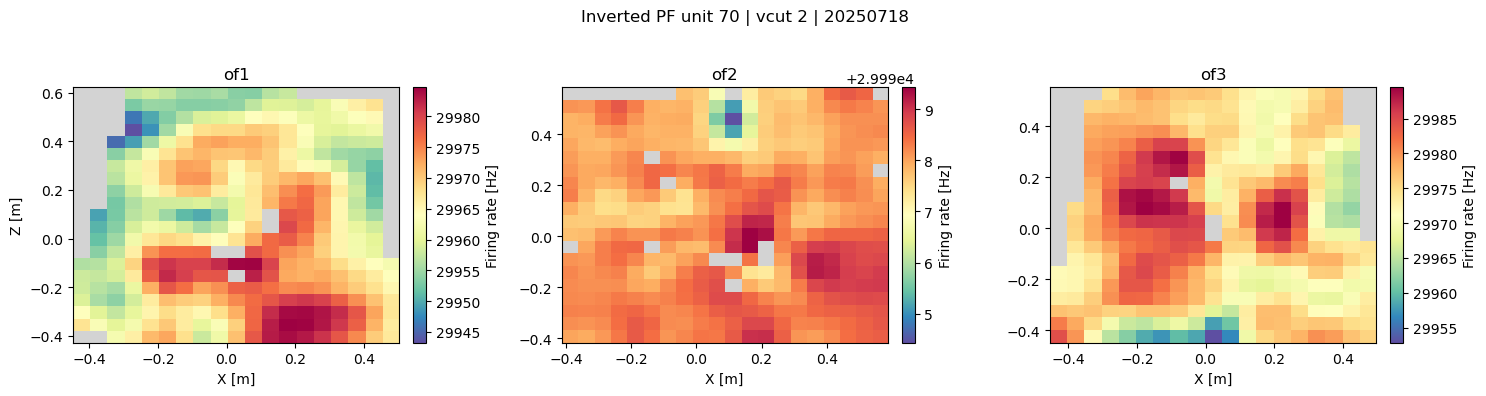

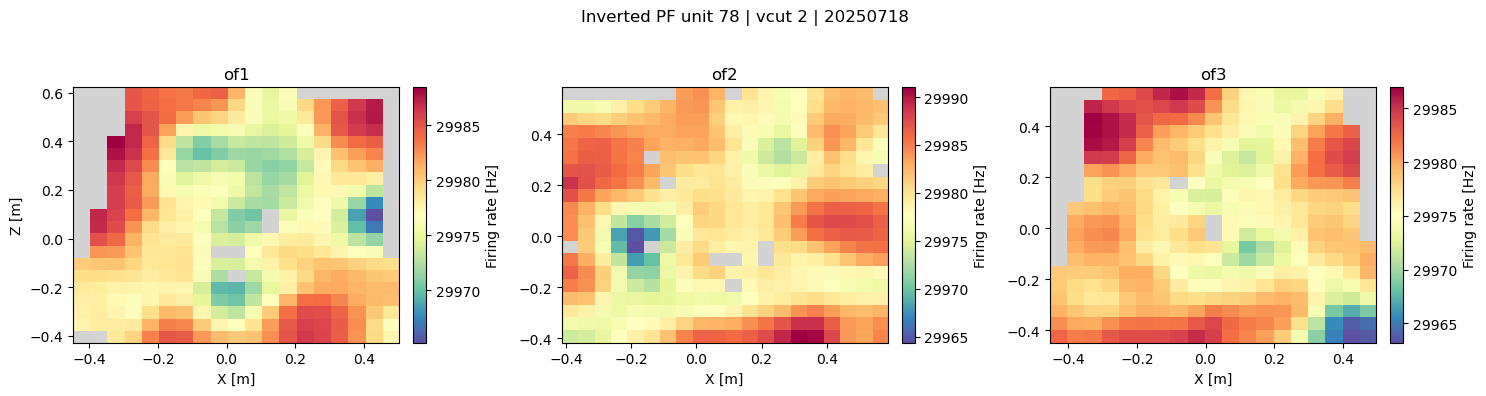

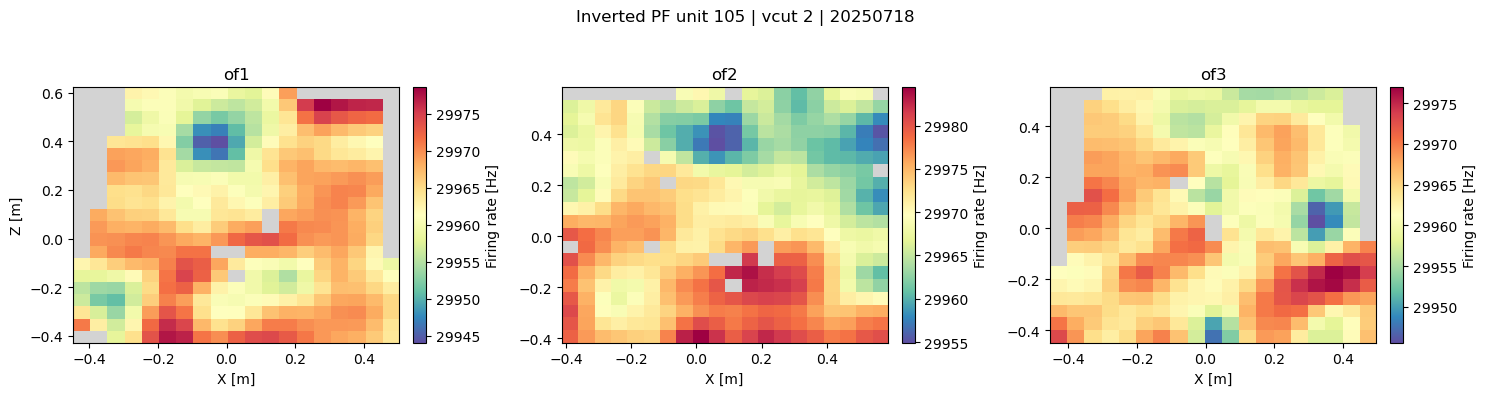

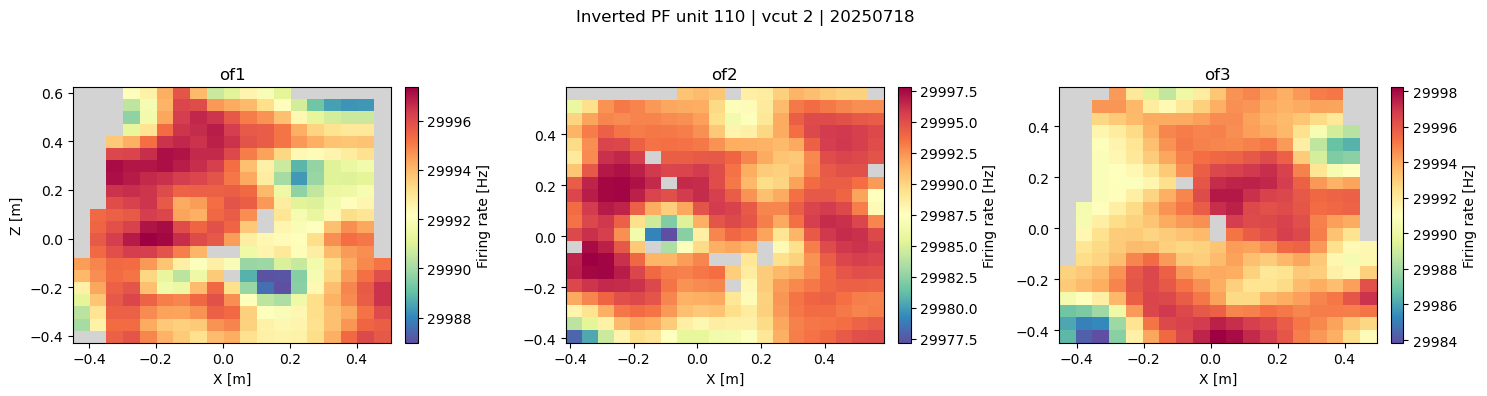

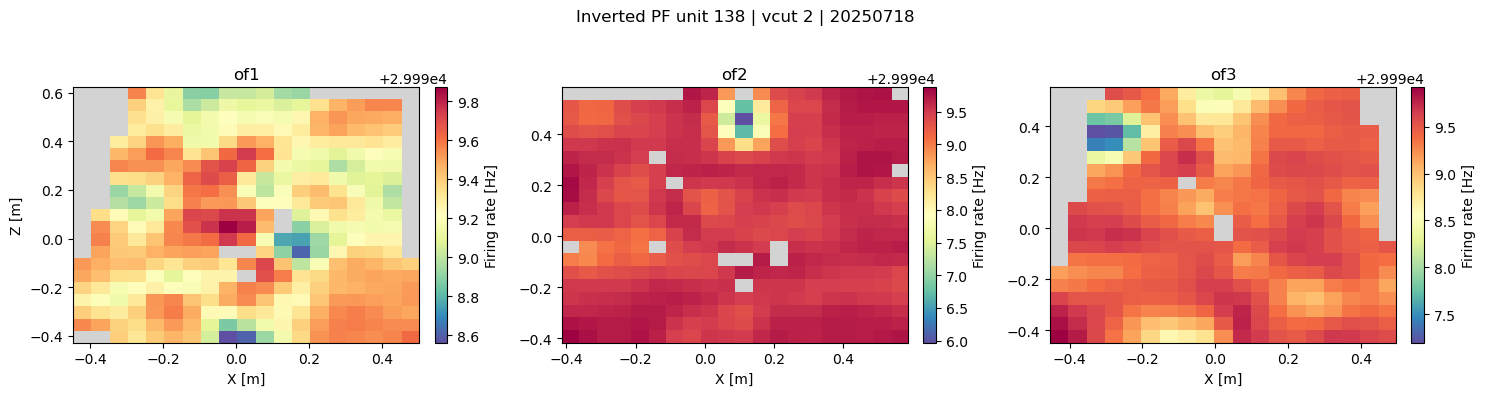

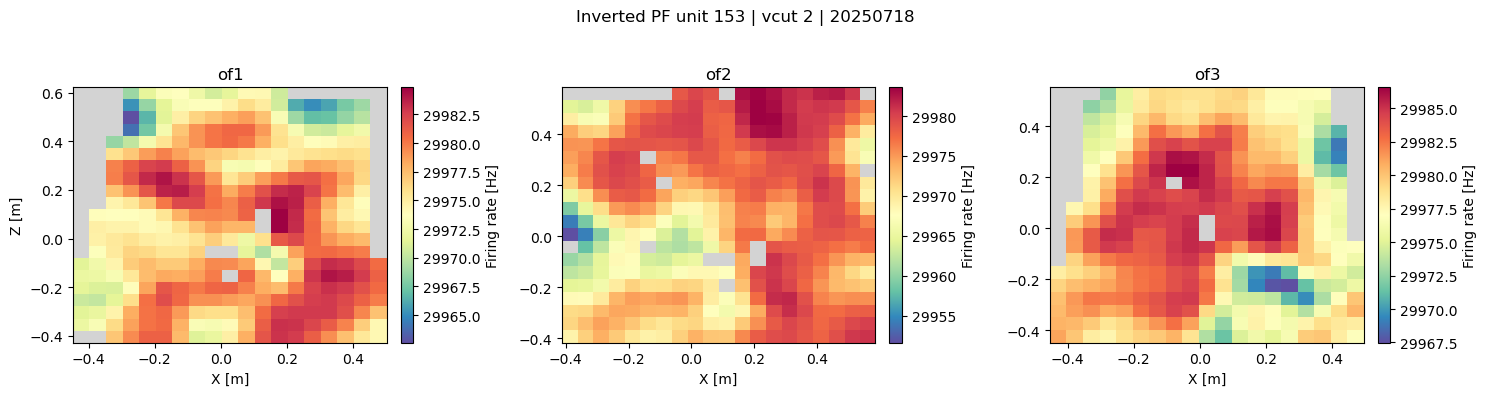

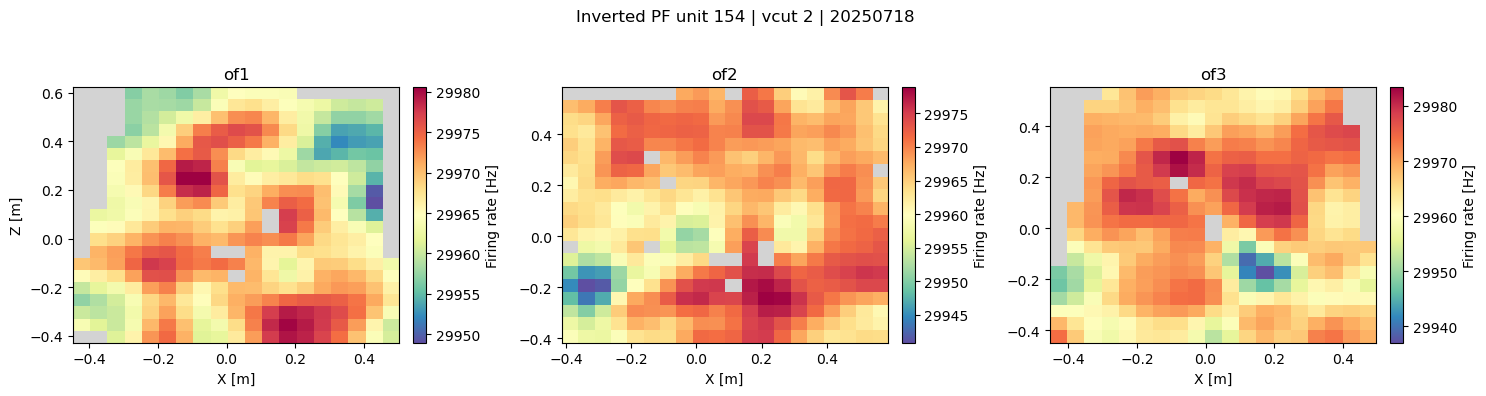

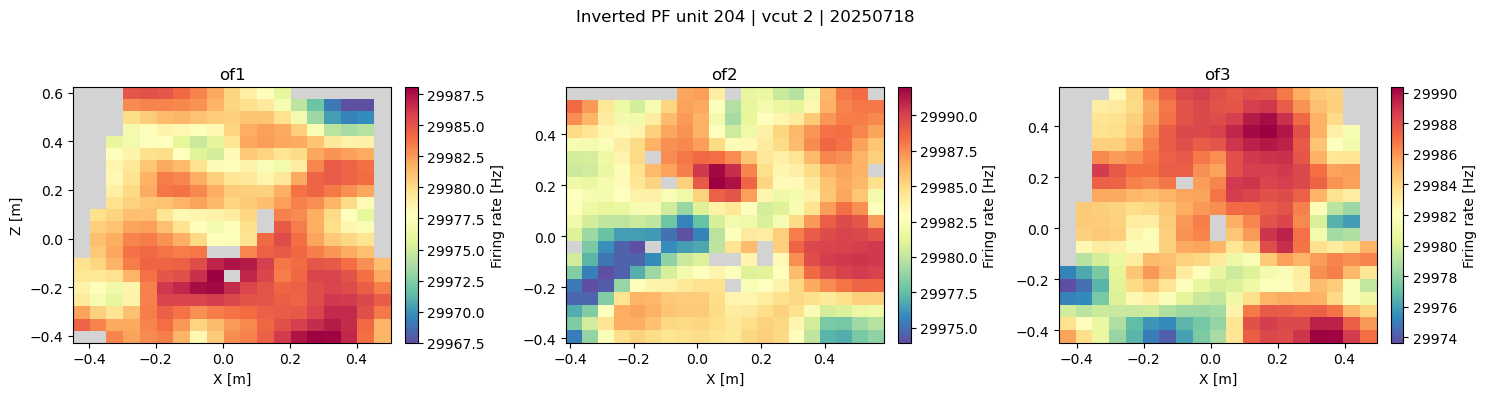

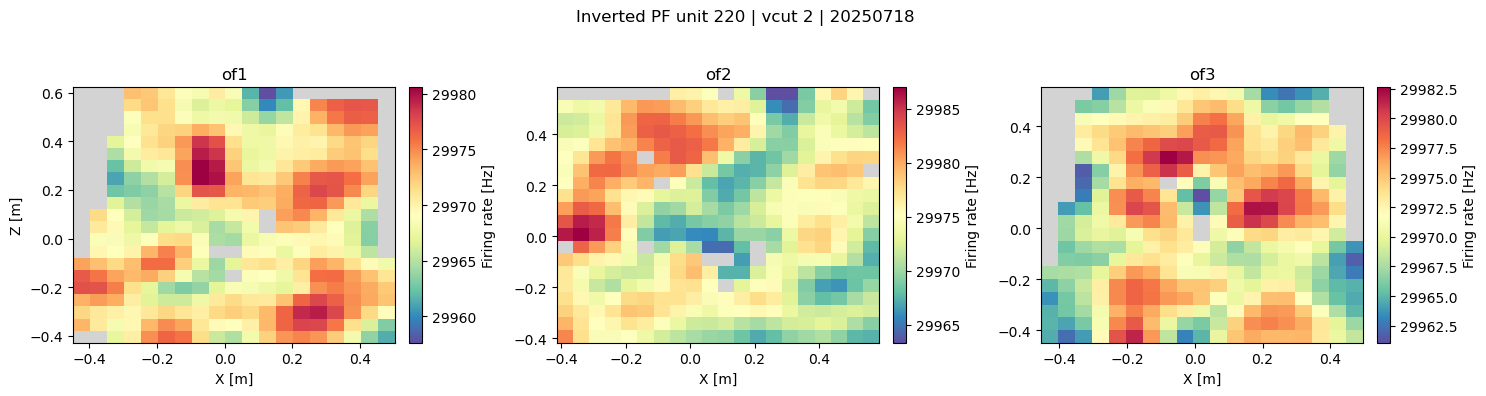

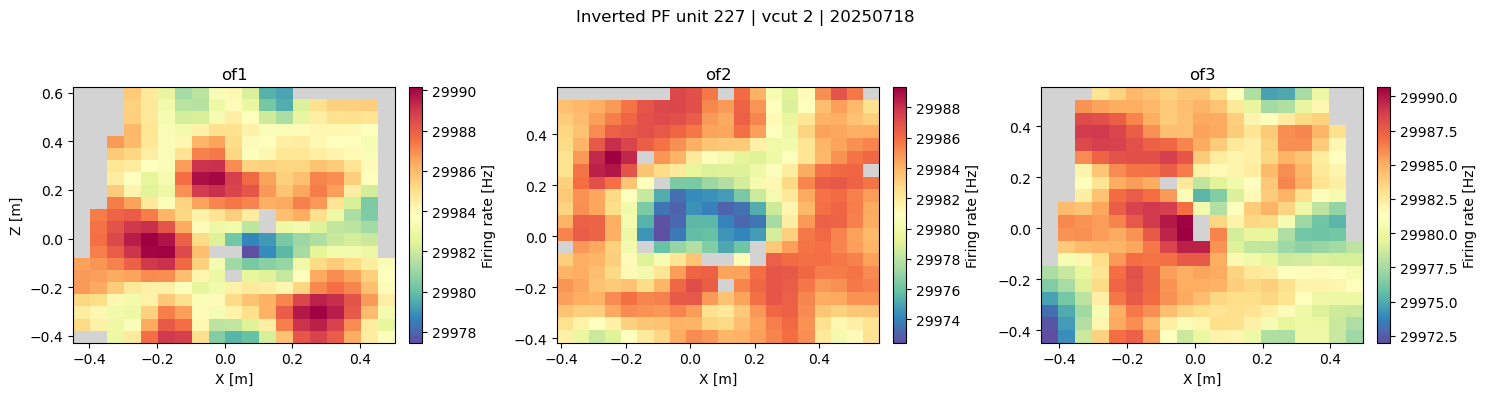

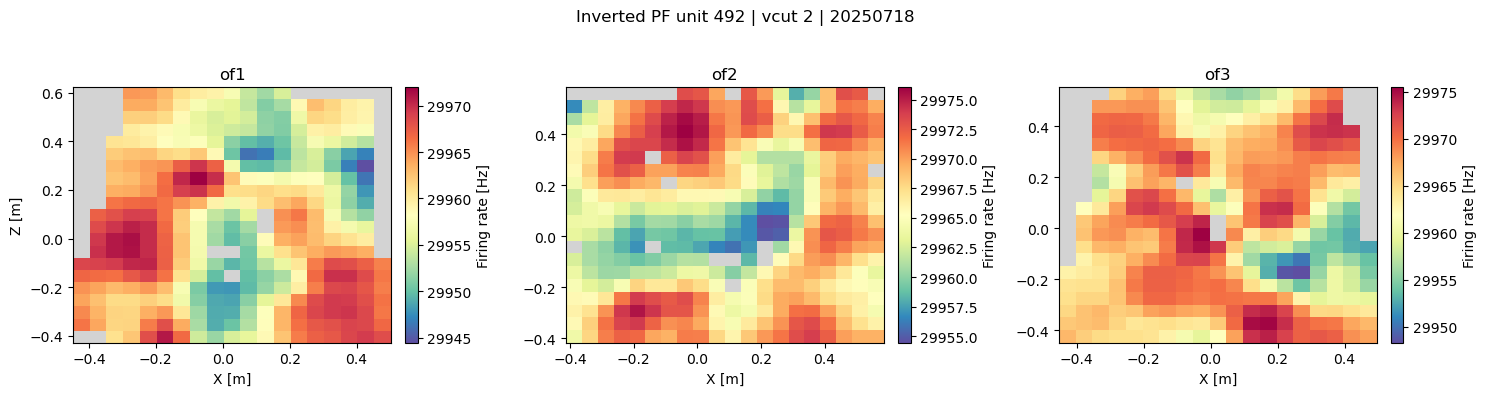

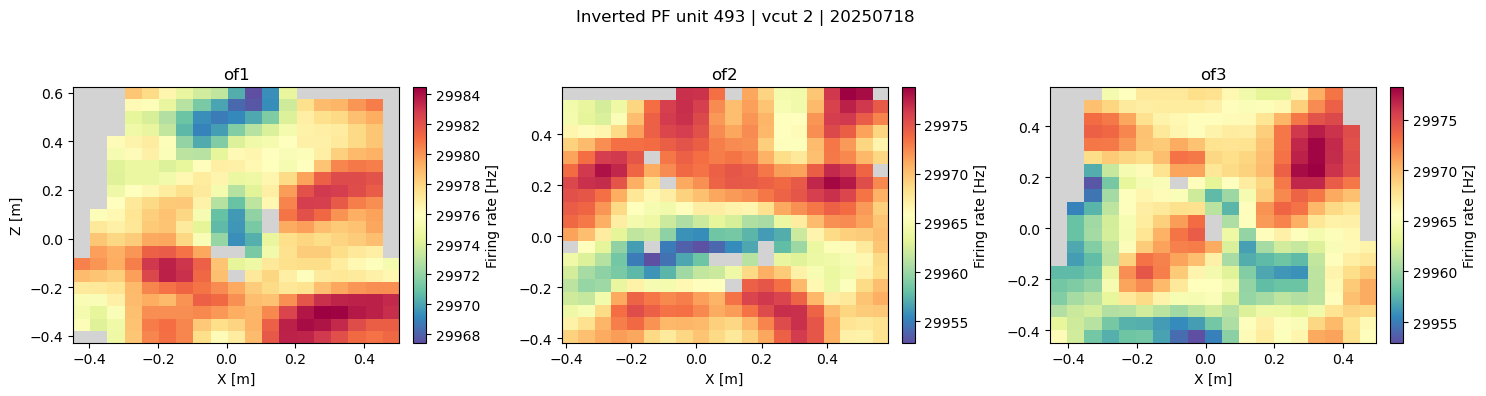

In [12]:
for unit in inter:
    plot_inter_rm_row(
        inter_rm=inter_rm,
        unit=unit,
        plotting_meta=plotting_meta,
        speed_cutoff=speed_cutoff,
        date=date
    )